# Facial Emotion Recogination

## Import libraries

In [12]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator, load_img
import cv2
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
#from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
#import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model

## Import data

In [13]:
train_data_dir = 'C:/Users/Grace/Desktop/Capstone project/data/train/'
test_data_dir = 'C:/Users/Grace/Desktop/Capstone project/data/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_data_count = count_exp(train_data_dir, 'train data')
test_data_count = count_exp(test_data_dir, 'test data')
print(train_data_count)
print(test_data_count)

            angry  disgust  fear  happy  neutral   sad  surprise
train data   3995      436  4097   7215     4965  4830      3171
           angry  disgust  fear  happy  neutral   sad  surprise
test data    958      111  1024   1774     1233  1247       831


### Bar chart for emotion images in train data

<AxesSubplot:>

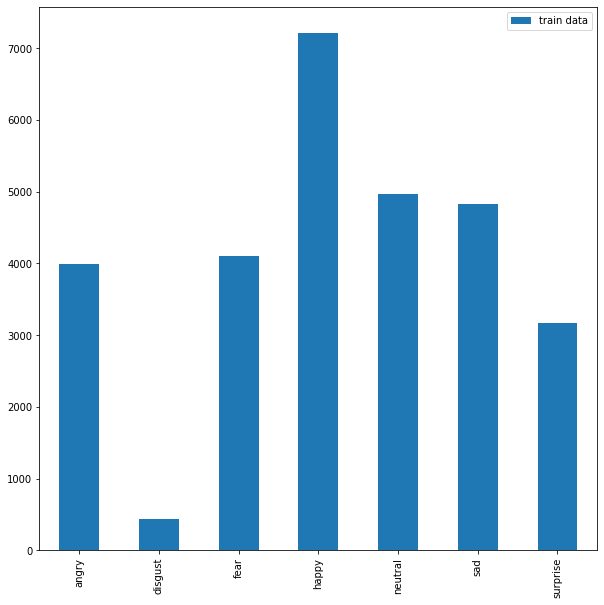

In [14]:
train_data_count.transpose().plot(kind='bar', figsize=(10,10))

### Bar chart for emotion images in test data

<AxesSubplot:>

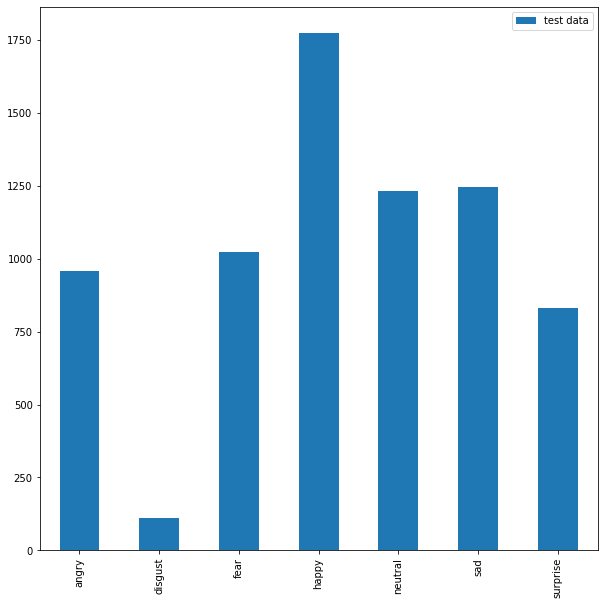

In [15]:
test_data_count.transpose().plot(kind='bar', figsize=(10,10))

### Examples of emotion images in dataset

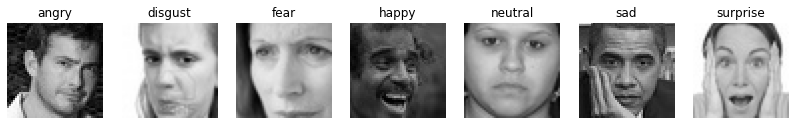

In [16]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_data_dir):
    img = load_img((train_data_dir + expression +'/'+ os.listdir(train_data_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Create Training and test datasets

In [17]:
train_data_generator = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_data_generator.flow_from_directory(train_data_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_data_generator = ImageDataGenerator(rescale=1./255)
test_set = test_data_generator.flow_from_directory(test_data_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [18]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Constructure Model

In [19]:
#def get_model(input_size, classes=7):
model = Sequential()   
    #model = tf.keras.models.Sequential()   

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
    
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    #return model

C:\Users\Grace\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [20]:
#fernet = get_model((row,col,1), classes)
#fernet.summary()

In [21]:
#plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

### Callbacks Function

In [22]:
"""chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]"""

'chk_path = \'ferNet.h5\'\nlog_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")\n\ncheckpoint = ModelCheckpoint(filepath=chk_path,\n                             save_best_only=True,\n                             verbose=1,\n                             mode=\'min\',\n                             moniter=\'val_loss\')\n\nearlystop = EarlyStopping(monitor=\'val_loss\', \n                          min_delta=0, \n                          patience=3, \n                          verbose=1, \n                          restore_best_weights=True)\n                        \nreduce_lr = ReduceLROnPlateau(monitor=\'val_loss\', \n                              factor=0.2, \n                              patience=6, \n                              verbose=1, \n                              min_delta=0.0001)\n\n\ntensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)\ncsv_logger = CSVLogger(\'training.log\')\n\ncallbacks = [checkpoint, red

## Training Model

In [23]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size
hist = model.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 #callbacks= callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - 297s 658ms/step - loss: 4.2408 - accuracy: 0.2811 - val_loss: 5.9991 - val_accuracy: 0.1920
Epoch 2/60
448/448 [==============================] - 253s 565ms/step - loss: 3.4458 - accuracy: 0.3349 - val_loss: 3.0562 - val_accuracy: 0.4071
Epoch 3/60
448/448 [==============================] - 247s 550ms/step - loss: 2.9426 - accuracy: 0.3655 - val_loss: 2.6677 - val_accuracy: 0.4148
Epoch 4/60
448/448 [==============================] - 247s 550ms/step - loss: 2.5444 - accuracy: 0.3924 - val_loss: 2.3467 - val_accuracy: 0.4316
Epoch 5/60
448/448 [==============================] - 246s 549ms/step - loss: 2.2371 - accuracy: 0.4211 - val_loss: 1.9773 - val_accuracy: 0.4837
Epoch 6/60
448/448 [==============================] - 245s 546ms/step - loss: 2.0025 - accuracy: 0.4452 - val_loss: 1.8022 - val_accuracy: 0.4911
Epoch 7/60
448/448 [==============================] - 250s 558ms/step - loss: 1.8266 - accuracy: 0.4703 - val_loss: 1.6395 -

## Loss and Accuracy plot

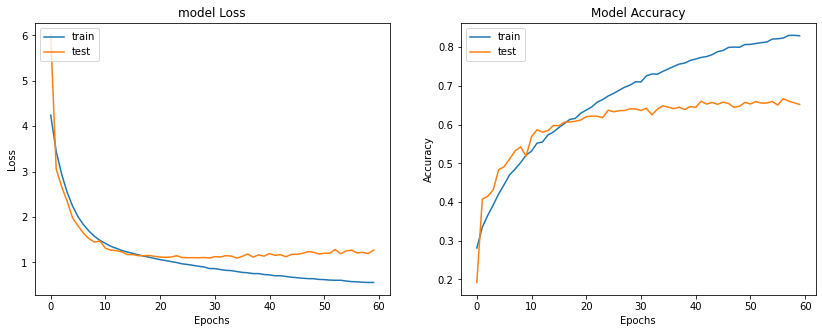

In [25]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

high accracy is achieved on training set but accuracy on validation set is stuck at 66% also no overfitting can se seen in the dataset hence is can be concluded that the inefficiency may be due to the unbalanced dataset

### Model evaluation

In [26]:
train_loss, train_accu = model.evaluate(training_set)
test_loss, test_accu = model.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 16s 144ms/step - loss: 1.2678 - accuracy: 0.6521
final train accuracy = 91.87 , validation accuracy = 65.21


### Serialize the model to JSON and save the model weights

In [50]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

### Confusion Matrix and Classification on training set

In [35]:
"""y_pred = model.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)"""

449/449 [==============================] - 58s 129ms/step


ModuleNotFoundError: No module named 'sklearn'

### Confusion Matrix and Classification on test set

In [32]:
"""y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)"""

113/113 [==============================] - 15s 130ms/step


NameError: name 'confusion_matrix' is not defined

### Import model weight and haar cascade file

In [57]:
from keras.models import model_from_json
from keras.preprocessing import image
model = model_from_json(open("model.json", "r").read())
model.load_weights('model.h5')
face_haar_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

### Construct frame to capture the image 

In [65]:
cap=cv2.VideoCapture(0)

while True:  
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image  
    if not ret:  
        continue  
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)  
  
    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)  
  
  
    for (x,y,w,h) in faces_detected:  
        cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)  
        roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image  
        roi_gray=cv2.resize(roi_gray,(48,48))  
        img_pixels = image.img_to_array(roi_gray)  
        img_pixels = np.expand_dims(img_pixels, axis = 0)  
        img_pixels /= 255  
  
        predictions = model.predict(img_pixels)  
  
        #find max indexed array  
        max_index = np.argmax(predictions[0])  
  
        emotions = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')  
        predicted_emotion = emotions[max_index]  
  
        cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)  
  
    resized_img = cv2.resize(test_img, (1000, 700))  
    cv2.imshow('Facial emotion analysis ',resized_img)  
  
  
  
    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed  
        break  
  
cap.release()  
cv2.destroyAllWindows  

KeyboardInterrupt: 